In [2]:
import pandas as pd
import numpy as np


# 指定汽车评估数据集的网址
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'

# 从网上直接读取数据，并指定分隔符为逗号
df = pd.read_csv(url, sep=',')

# 查看数据集的基本信息
print(df.head())
print(df.shape)

# 将最后一列作为类别标签，并将其转换为数值型
y = df.iloc[:,-1]
#改为二分类
y = y.replace({'unacc':0, 'acc':1, 'good':0, 'vgood':0})
# 将前六列作为特征矩阵，并将其转换为数值型
X = df.iloc[:,:-1]
X = pd.get_dummies(X) # 使用one-hot编码处理类别型特征

# 查看X和y的基本信息
print(X.head())
print(X.shape)
print(y.head())
print(y.shape)



   vhigh vhigh.1  2 2.1  small   low  unacc
0  vhigh   vhigh  2   2  small   med  unacc
1  vhigh   vhigh  2   2  small  high  unacc
2  vhigh   vhigh  2   2    med   low  unacc
3  vhigh   vhigh  2   2    med   med  unacc
4  vhigh   vhigh  2   2    med  high  unacc
(1727, 7)
   vhigh_high  vhigh_low  vhigh_med  vhigh_vhigh  vhigh.1_high  vhigh.1_low  \
0           0          0          0            1             0            0   
1           0          0          0            1             0            0   
2           0          0          0            1             0            0   
3           0          0          0            1             0            0   
4           0          0          0            1             0            0   

   vhigh.1_med  vhigh.1_vhigh  2_2  2_3  ...  2_5more  2.1_2  2.1_4  2.1_more  \
0            0              1    1    0  ...        0      1      0         0   
1            0              1    1    0  ...        0      1      0         0   
2       

In [33]:
# 导入必要的库
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel

#创建SVC模型，设置两个不同的核函数
svm_rbf=SVC(kernel='rbf',probability=True)
svm_poly = SVC(kernel='poly',probability=True)

#保存名称信息
svm_rbf.__str__="svm_rbf"
svm_poly.__str__="svm_poly"

#得到每一折的准确率

svm_rbf_scores = cross_val_score(svm_rbf, X, y, cv=10, scoring='accuracy')


svm_poly_scores = cross_val_score(svm_poly, X, y, cv=10, scoring='accuracy')


_,p=ttest_rel(svm_rbf_scores,svm_poly_scores)
alpha = 0.05 # 设置显著

if p>alpha:
    print('模型性能有显著差异，且模型%s性能较优' %svm_rbf.__str__ if np.mean(svm_rbf_scores)>np.mean(svm_poly_scores) else svm_poly_scores)
else:
    print("模型无显著差异")

SVM1 scores: [0.71676301 0.75144509 0.9132948  0.87861272 0.92485549 0.91907514
 0.89017341 0.72093023 0.70348837 0.65697674]
SVM! mean score: 0.8075615002016401
SVM2 scores: [0.67630058 0.78612717 0.94219653 0.95953757 0.90751445 0.96531792
 0.87283237 0.88372093 0.76744186 0.73837209]
SVM2 mean score: 0.8499361473316306
TtestResult(statistic=-2.239431715820268, pvalue=0.05189139879270175, df=9)


svm_rbf:
[-3.37727805 -2.05691354 -2.75228503 -2.4317223  -1.62155247 -2.50891328
 -1.6979639  -1.43831185 -2.45160773 -2.35678599]
Confusion Matrix:
[[1145  198]
 [ 134  250]]
Accuracy: 0.8078
Precision: 0.5580
Recall: 0.6510
F1 Score: 0.6010
svm_poly:
[-5.23189921 -2.31836    -3.10406331 -3.56852644 -2.10549327 -2.04480532
 -1.47025486 -1.36530823 -2.96083703 -4.00351881]
Confusion Matrix:
[[1206  137]
 [ 122  262]]
Accuracy: 0.8500
Precision: 0.6566
Recall: 0.6823
F1 Score: 0.6692


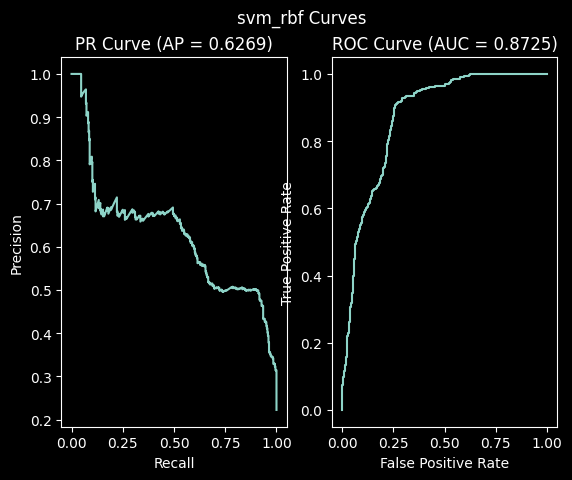

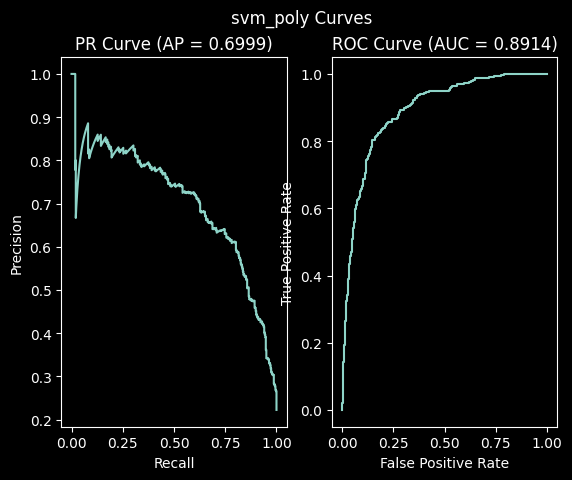

In [34]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict, cross_val_score
import matplotlib.pyplot as plt


# 定义一个函数来绘制P-R曲线和ROC曲线
def plot_curves(y_true, y_prob, label):
  # 计算P-R曲线上的点
  print(y_prob[:10])
  
  # y_prob:Target scores, can either be probability estimates of the positive class, or non-thresholded measure of decisions (as returned by decision_function on some classifiers).

  p, r, _ = precision_recall_curve(y_true, y_prob)
  # 计算P-R曲线下面积（AP）
  ap = auc(r, p)
  # 计算ROC曲线上的点
  fpr, tpr, _ = roc_curve(y_true, y_prob)
  # 计算ROC曲线下面积（AUC）
  auc_value = auc(fpr, tpr)
  # 绘制子图
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle(label + ' Curves')
  # 绘制P-R曲线
  ax1.plot(r,p)
  ax1.set_xlabel('Recall')
  ax1.set_ylabel('Precision')
  ax1.set_title('PR Curve (AP = %.4f)' % ap)
  # 绘制ROC曲线
  ax2.plot(fpr,tpr)
  ax2.plot([0.5], [0.5], linestyle='--')
  ax2.set_xlabel('False Positive Rate')
  ax2.set_ylabel('True Positive Rate')
  ax2.set_title('ROC Curve (AUC = %.4f)' % auc_value)
# 创建一个分层10折交叉验证分割器对象（可根据需要调整）
skf = StratifiedKFold(n_splits=10)


# 对每个分类器进行循环
for clf in [svm_rbf,svm_poly]:
    # 获取分类器名称
    label=clf.__str__
    print(label + ':')
    # 得到预测的类别标签（使用cross_val_predict方法）
    y_pred = cross_val_predict(clf,X,y,cv=skf,n_jobs=-1)
    plot_curves(y,cross_val_predict(clf,X,y,cv=skf,n_jobs=-1,method='decision_function'),label)
    
    # 计算并打印混淆矩阵
    cm = confusion_matrix(y,y_pred)
    print('Confusion Matrix:')
    print(cm)
    
    
    #计算并打印准确率 (A)
    a=accuracy_score(y,y_pred)
    print('Accuracy: %.4f' % a)
    # 计算并打印精确率（P）
    p = precision_score(y,y_pred )
    print('Precision: %.4f' % p)
    # 计算并打印召回率（R）
    r = recall_score(y,y_pred )
    print('Recall: %.4f' % r)
    # 计算并打印F1值（F1）
    f1 = f1_score(y,y_pred )
    print('F1 Score: %.4f' % f1) 
  
    


cost：为逻辑回归的损失函数，反映了模型预测值和真实值之间的差异程度。其计算公式为二分类交叉熵损失函数：$J(w,b)=-\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} ln (a^{(i)})+(1-y^{(i)}) ln (1-a^{(i)})] $ 。其中，$a^{(i)}$ 为模型对第 $i$ 个样本的预测结果， $y^{(i)}$ 为第 $i$ 个样本的真实标签。

dw: 是损失函数对$w$参数的梯度，表示了每次迭代$w$参数的更新方向和大小。其计算公式为：$dw=\frac{1}{m}X^T(a-y)$。其中，$X$为样本矩阵，$a$为模型对样本的预测值，$y$为样本的真实值。

db: 是损失函数对 $b$ 参数的梯度，表示了每次迭代 $b$ 参数的更新方向和大小。其计算公式为：$db=\frac{1}{m}\sum_{i=1}^{m}(a^{(i)}-y^{(i)})$

对于一个对角矩阵B，假设其对角线上的元素是d1, d2, …, dn。那么我们可以令矩阵A为：

A = \begin{pmatrix}
ln(d1) & 0 & \cdots & 0 \
0 & ln(d2) & \cdots & 0 \
\vdots & \vdots & \ddots & \vdots \
0 & 0 & \cdots & ln(dn)
\end{pmatrix}

这里的ln表示自然对数。那么根据指数函数的性质，我们可以得到：

e^A = \begin{pmatrix}
e^{ln(d1)} & 0 & \cdots & 0 \
0 & e^{ln(d2)} & \cdots & 0 \
\vdots & \vdots & \ddots & \vdots \
0 & 0 & \cdots & e^{ln(dn)}
\end{pmatrix} = \begin{pmatrix}
d1 & 0 & \cdots & 0 \
0 & d2 & \cdots & 0 \
\vdots & \vdots & \ddots & \vdots \
0 & 0 & \cdots & dn
\end{pmatrix} = B

因此，对于任意的对角矩阵B，都存在一个矩阵A使得e^A=B。

